# Машинное обучение, ФКН ВШЭ

# Практическое задание 11. Несбалансированные задачи

## Общая информация
Дата выдачи: 23.04.2024

Мягкий дедлайн: 13.05.2024 23:59 MSK

Жесткий дедлайн: 18.05.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

from tqdm.auto import tqdm

**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [2]:
"""%%bash
kaggle datasets download -d mlg-ulb/creditcardfraud
unzip creditcardfraud.zip""";

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [5]:
#your code here
class_one = df[df['Class']==1].count().iloc[1]
size = df.shape[0]
print(f"{class_one / size * 100} percent of class 1 transactions")

0.1727485630620034 percent of class 1 transactions


Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [6]:
#your code here
df['Day'] = df['Time'] // (3600 * 24)
df['Hour'] = (df['Time'] - df['Day'] * (3600 * 24)) // 3600
df.sample(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Day,Hour
134724,80932.0,-0.622987,-0.035982,2.525149,-2.070185,-0.711837,0.363246,-0.531527,0.311388,-1.110331,-0.051961,0.450834,-0.387936,0.616433,-0.686342,0.059154,2.276422,-0.833979,0.187952,0.207244,0.182500,0.490149,1.249880,-0.481858,-0.457561,0.421080,-0.093787,0.068231,0.056158,17.50,0,0.0,22.0
18900,29852.0,1.348763,-1.043629,0.030010,-1.343685,-1.109502,-0.747432,-0.501143,-0.254187,-2.210874,1.348391,-0.067171,-0.468433,0.875653,-0.137143,0.570954,-0.875894,0.875658,-1.065578,-0.350987,-0.185763,-0.486298,-1.188713,0.167372,0.028640,0.151619,-0.508598,0.014638,0.030202,89.85,0,0.0,8.0
220069,142008.0,1.905455,-0.919774,-1.555953,-0.502141,0.301364,0.863037,-0.420524,0.107457,-0.439966,0.581409,-0.311255,0.656054,1.124349,0.129999,1.148392,-2.714576,0.615309,-0.119028,-2.106615,-0.515242,0.079123,0.861439,0.070042,-0.311335,0.018588,0.038033,0.052978,-0.044267,79.00,0,1.0,15.0
243965,152149.0,-2.886272,-2.573023,0.146665,3.356829,4.126278,-0.363776,-1.713843,-0.802314,-0.343890,1.992521,-0.667702,0.053634,0.089157,-0.199364,-1.371359,1.941080,-1.924419,0.443376,-0.930072,-1.774029,0.215205,-0.556149,-0.578907,-0.284912,-2.540703,-0.742287,1.061987,-0.182410,187.33,0,1.0,18.0
271735,164716.0,1.213631,1.935345,-1.795351,4.945315,1.219216,1.175586,-1.079268,-2.516578,-2.346929,0.261010,1.322316,0.038604,0.814827,-2.298415,0.690457,1.727177,1.915835,2.055530,0.401145,0.910662,-1.337913,0.211455,-0.009989,-0.172026,0.785481,0.512902,-0.086168,-0.007929,1.51,0,1.0,21.0
58580,48454.0,-0.150422,-0.124346,0.640457,-0.242588,1.378997,4.955806,-0.213667,0.581053,-0.045859,1.105801,-1.264658,-0.176120,-0.137106,-1.307366,-1.587234,-2.683819,0.350453,1.122642,1.233555,-0.285205,-0.786477,-1.183276,0.032552,0.963909,-0.778080,-0.618276,-0.374824,-0.280290,79.00,0,0.0,13.0
193664,130237.0,-1.685392,1.527428,-0.176295,-0.694380,0.652041,0.528847,0.439253,0.635049,0.229310,0.276673,-0.426176,0.219183,-0.317026,0.342851,0.819888,-1.209375,0.782939,-2.044807,-0.629053,0.059920,-0.232073,-0.231146,0.093038,-1.129782,-0.574839,0.291997,-0.237884,-0.252154,8.95,0,1.0,12.0
278443,168227.0,0.081664,-1.080640,1.003764,-0.275640,0.649014,5.568477,-2.075723,1.520543,0.227513,0.511920,-1.183286,0.004777,0.232337,-1.174751,-0.049816,-2.847455,1.238030,1.644251,2.049616,0.011555,-0.129645,0.520570,0.186781,0.783244,-1.232509,1.113567,0.340353,0.235480,50.00,0,1.0,22.0
227746,145203.0,-0.196039,0.953201,-0.340131,0.081027,1.057357,-0.436054,0.715748,0.013405,-0.249797,-0.509362,1.332236,0.726676,0.082940,-0.849968,-0.104018,-0.233599,0.723063,0.548032,1.120595,0.167572,-0.210223,-0.457428,0.122461,0.575301,-0.456393,-0.524226,0.218740,0.190447,9.99,0,1.0,16.0
268236,163123.0,-0.874662,1.832617,0.463570,4.237443,0.775147,0.583194,0.281252,0.488934,-2.080839,1.667355,-1.572167,-1.287998,-0.817131,0.881101,0.881199,0.046085,0.258011,0.021886,1.459011,0.126615,-0.195583,-0.767844,-0.015041,0.395357,-0.509229,0.058948,0.018297,0.148732,6.01,0,1.0,21.0


In [7]:
print(f'Данные покрывают {round(df.Time.max() / (3600 * 24), 4)} дней, что 1 день и 23 часа' )

Данные покрывают 1.9999 дней, что 1 день и 23 часа


Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

<Axes: xlabel='Hour', ylabel='Count'>

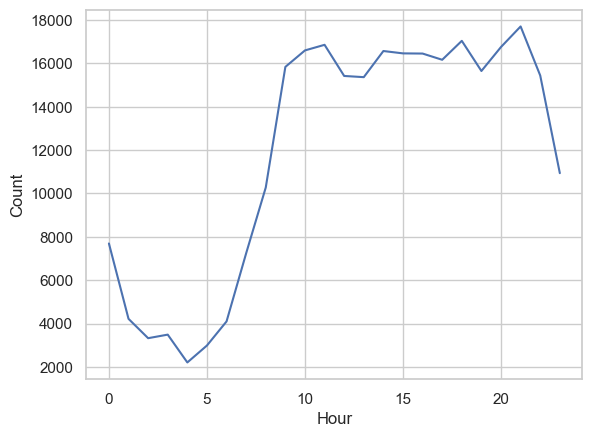

In [8]:
#your code here
sns.lineplot(data=df.groupby(['Hour']).count().rename(columns={'Hour' : 'Hour', 'Time':'Count'}), x='Hour', y='Count')

Text(0.5, 1.0, 'Распределение доли мошеннических \n транзакций по каждому дню')

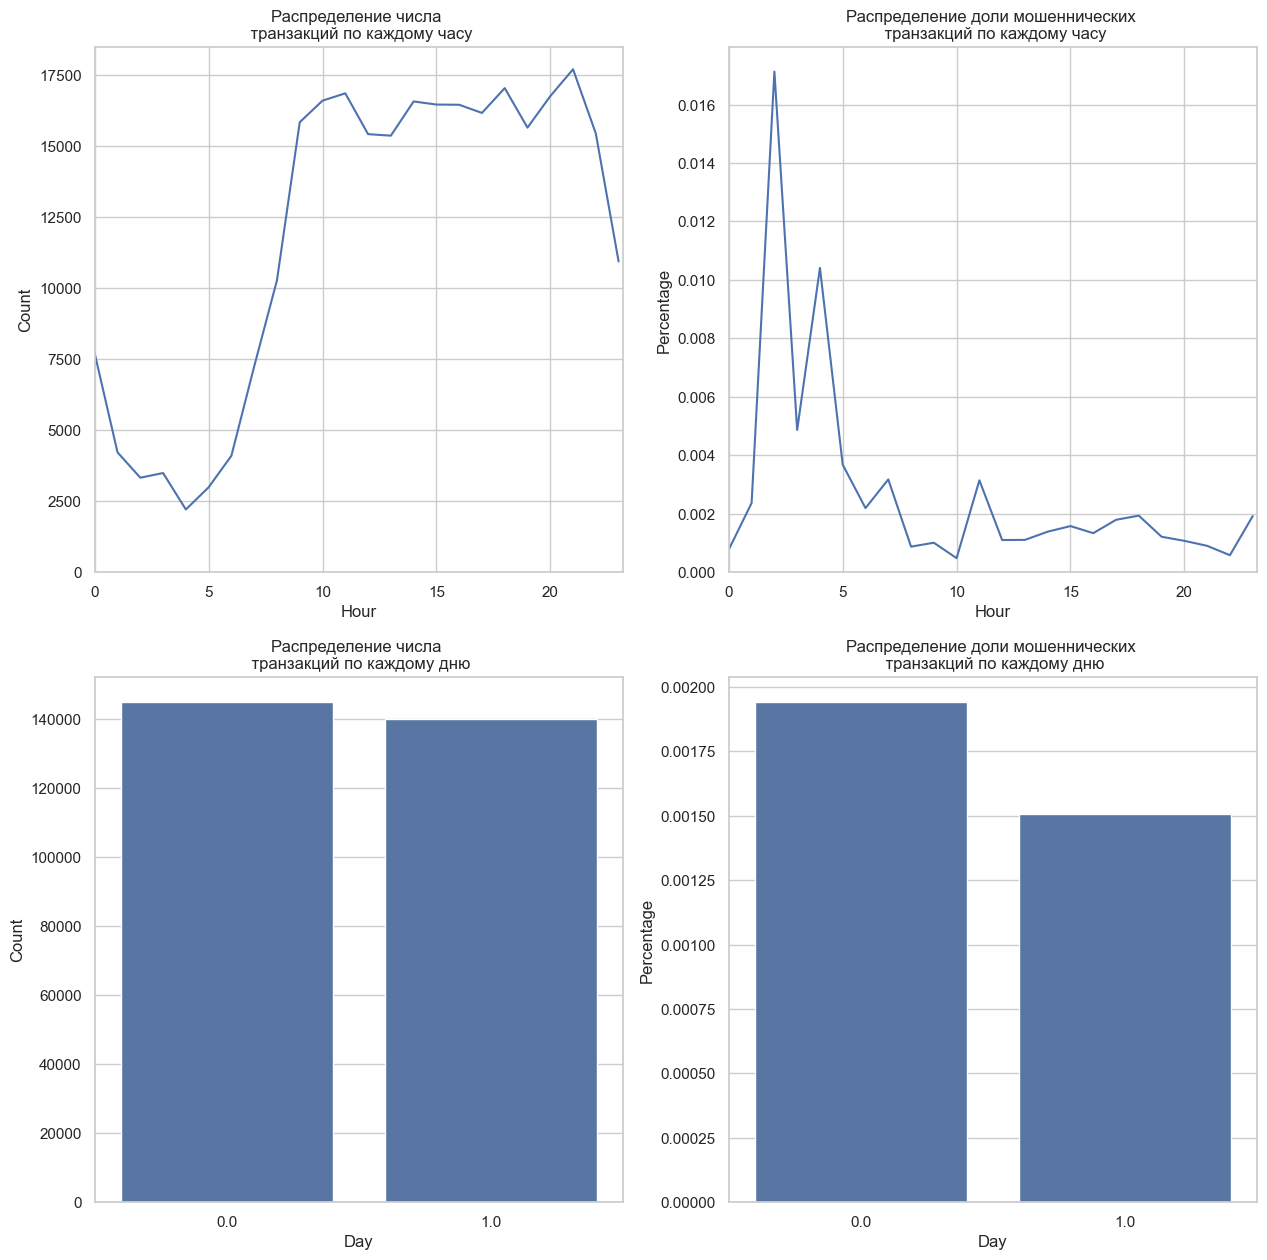

In [9]:
_, ax = plt.subplots(2, 2,figsize=(15, 15))

sns.lineplot(data=df.groupby(['Hour']).count()
             .rename(columns={'Hour' : 'Hour', 'Time':'Count'}), x='Hour', y='Count', ax=ax[0][0]).set(xlim=(0,23.2), ylim=0)
ax[0][0].set_title("Распределение числа \n транзакций по каждому часу")

sns.lineplot(data=( df[df['Class'] == 1].groupby(['Hour']).count() / df.groupby(['Hour']).count() )
             .rename(columns={'Hour' : 'Hour', 'Time':'Percentage'}), x='Hour', y='Percentage', ax=ax[0][1]).set(xlim=(0,23.2), ylim=0)
ax[0][1].set_title('Распределение доли мошеннических \n транзакций по каждому часу')

sns.barplot(data=df.groupby(['Day']).count()
             .rename(columns={'Day' : 'Day', 'Time':'Count'}), x='Day', y='Count', ax=ax[1][0])
ax[1][0].set_title("Распределение числа \n транзакций по каждому дню")

sns.barplot(data=( df[df['Class'] == 1].groupby(['Day']).count() / df.groupby(['Day']).count() )
             .rename(columns={'Day' : 'Day', 'Time':'Percentage'}), x='Day', y='Percentage', ax=ax[1][1])
ax[1][1].set_title('Распределение доли мошеннических \n транзакций по каждому дню')

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

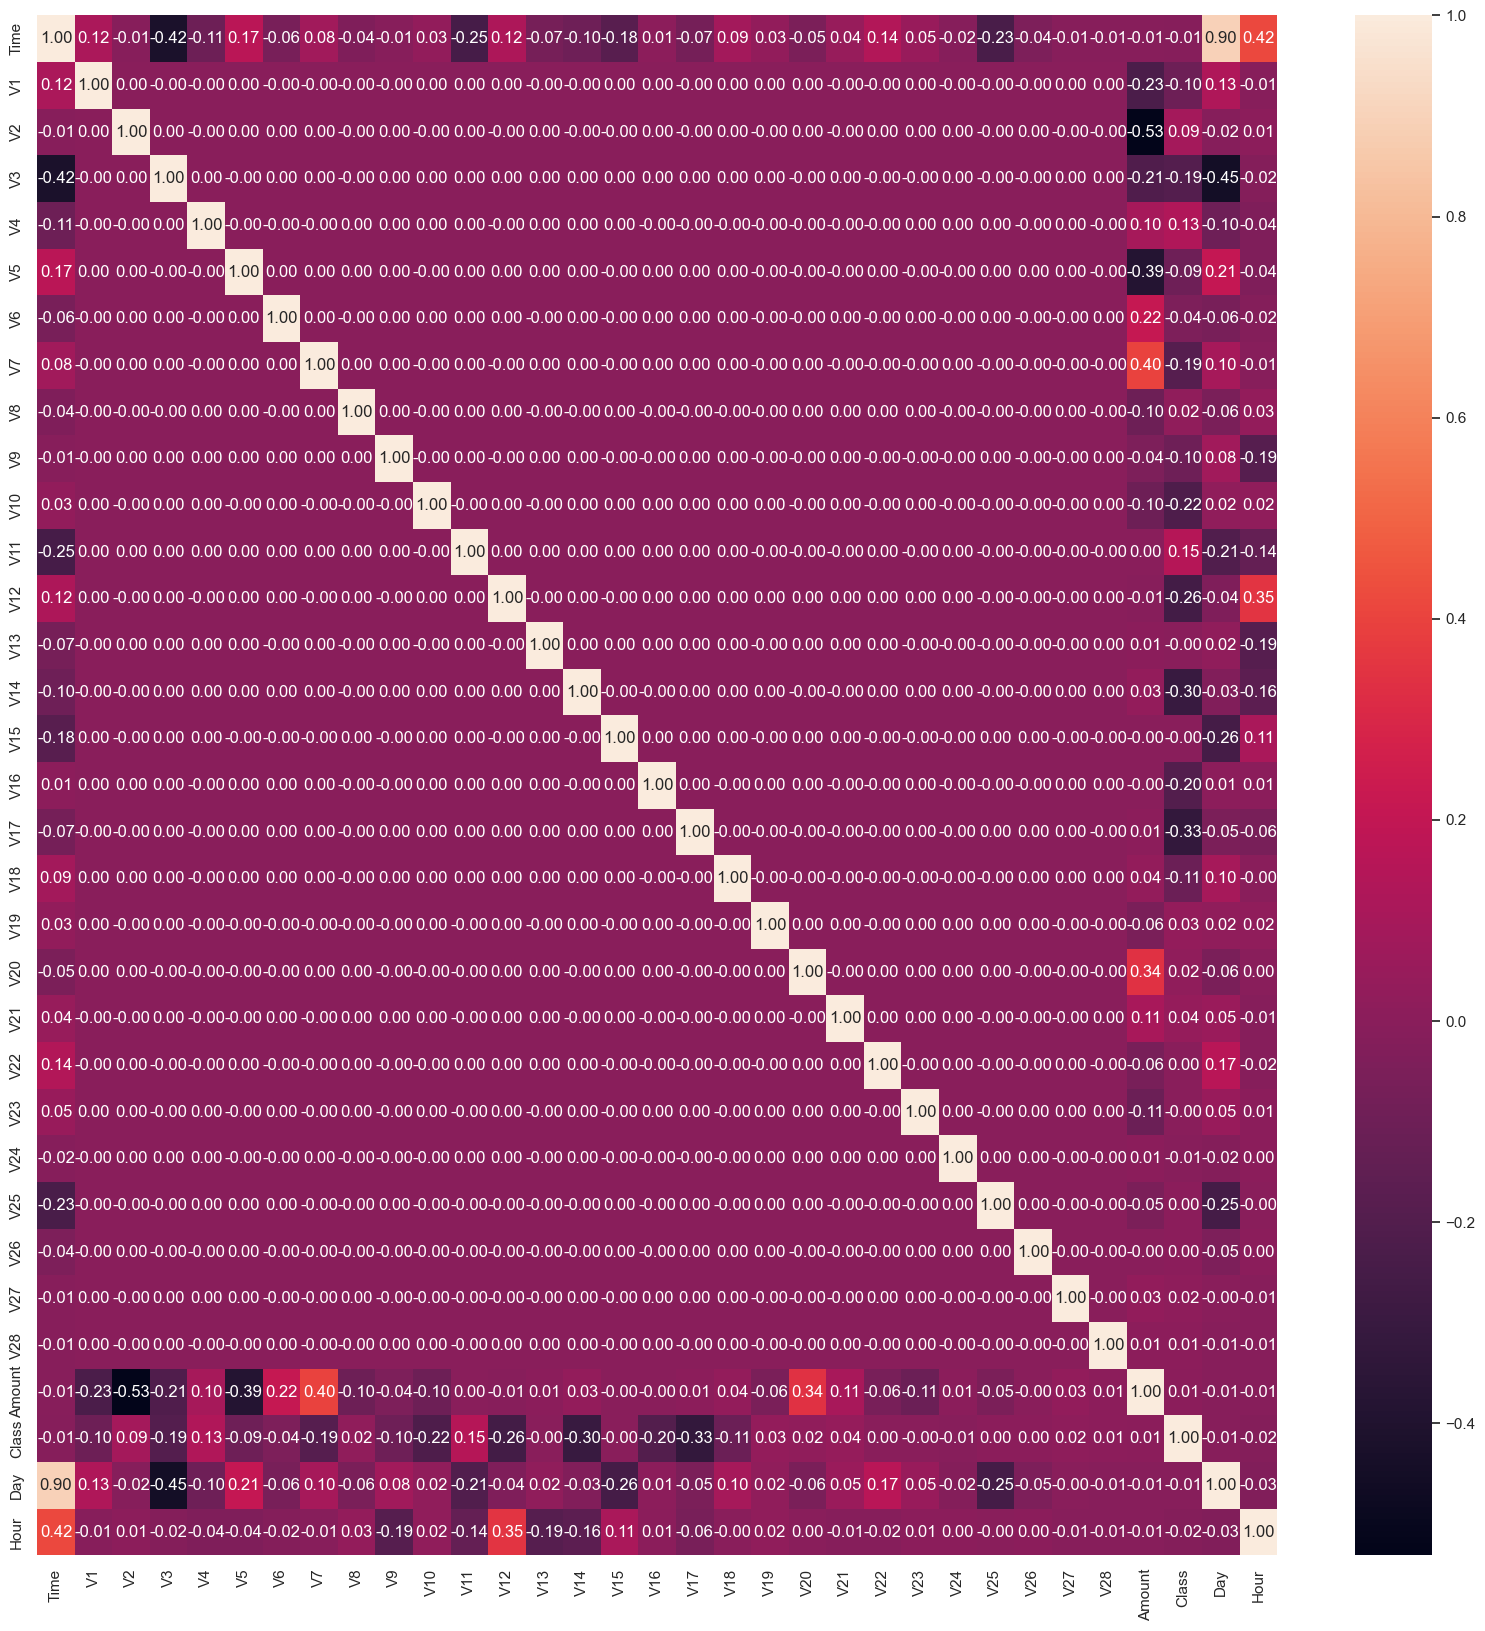

In [10]:
#your code here
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()

Выберем некоторые наиболее значимые признаки для столбца Class

In [11]:
valuable_columns = [ 'V1', 'V2', 'V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Day', 'Hour']
len(valuable_columns)

16

Чтобы сделать графики покрасивше, добавим еще Day и Hour (мало ли что вдруг)

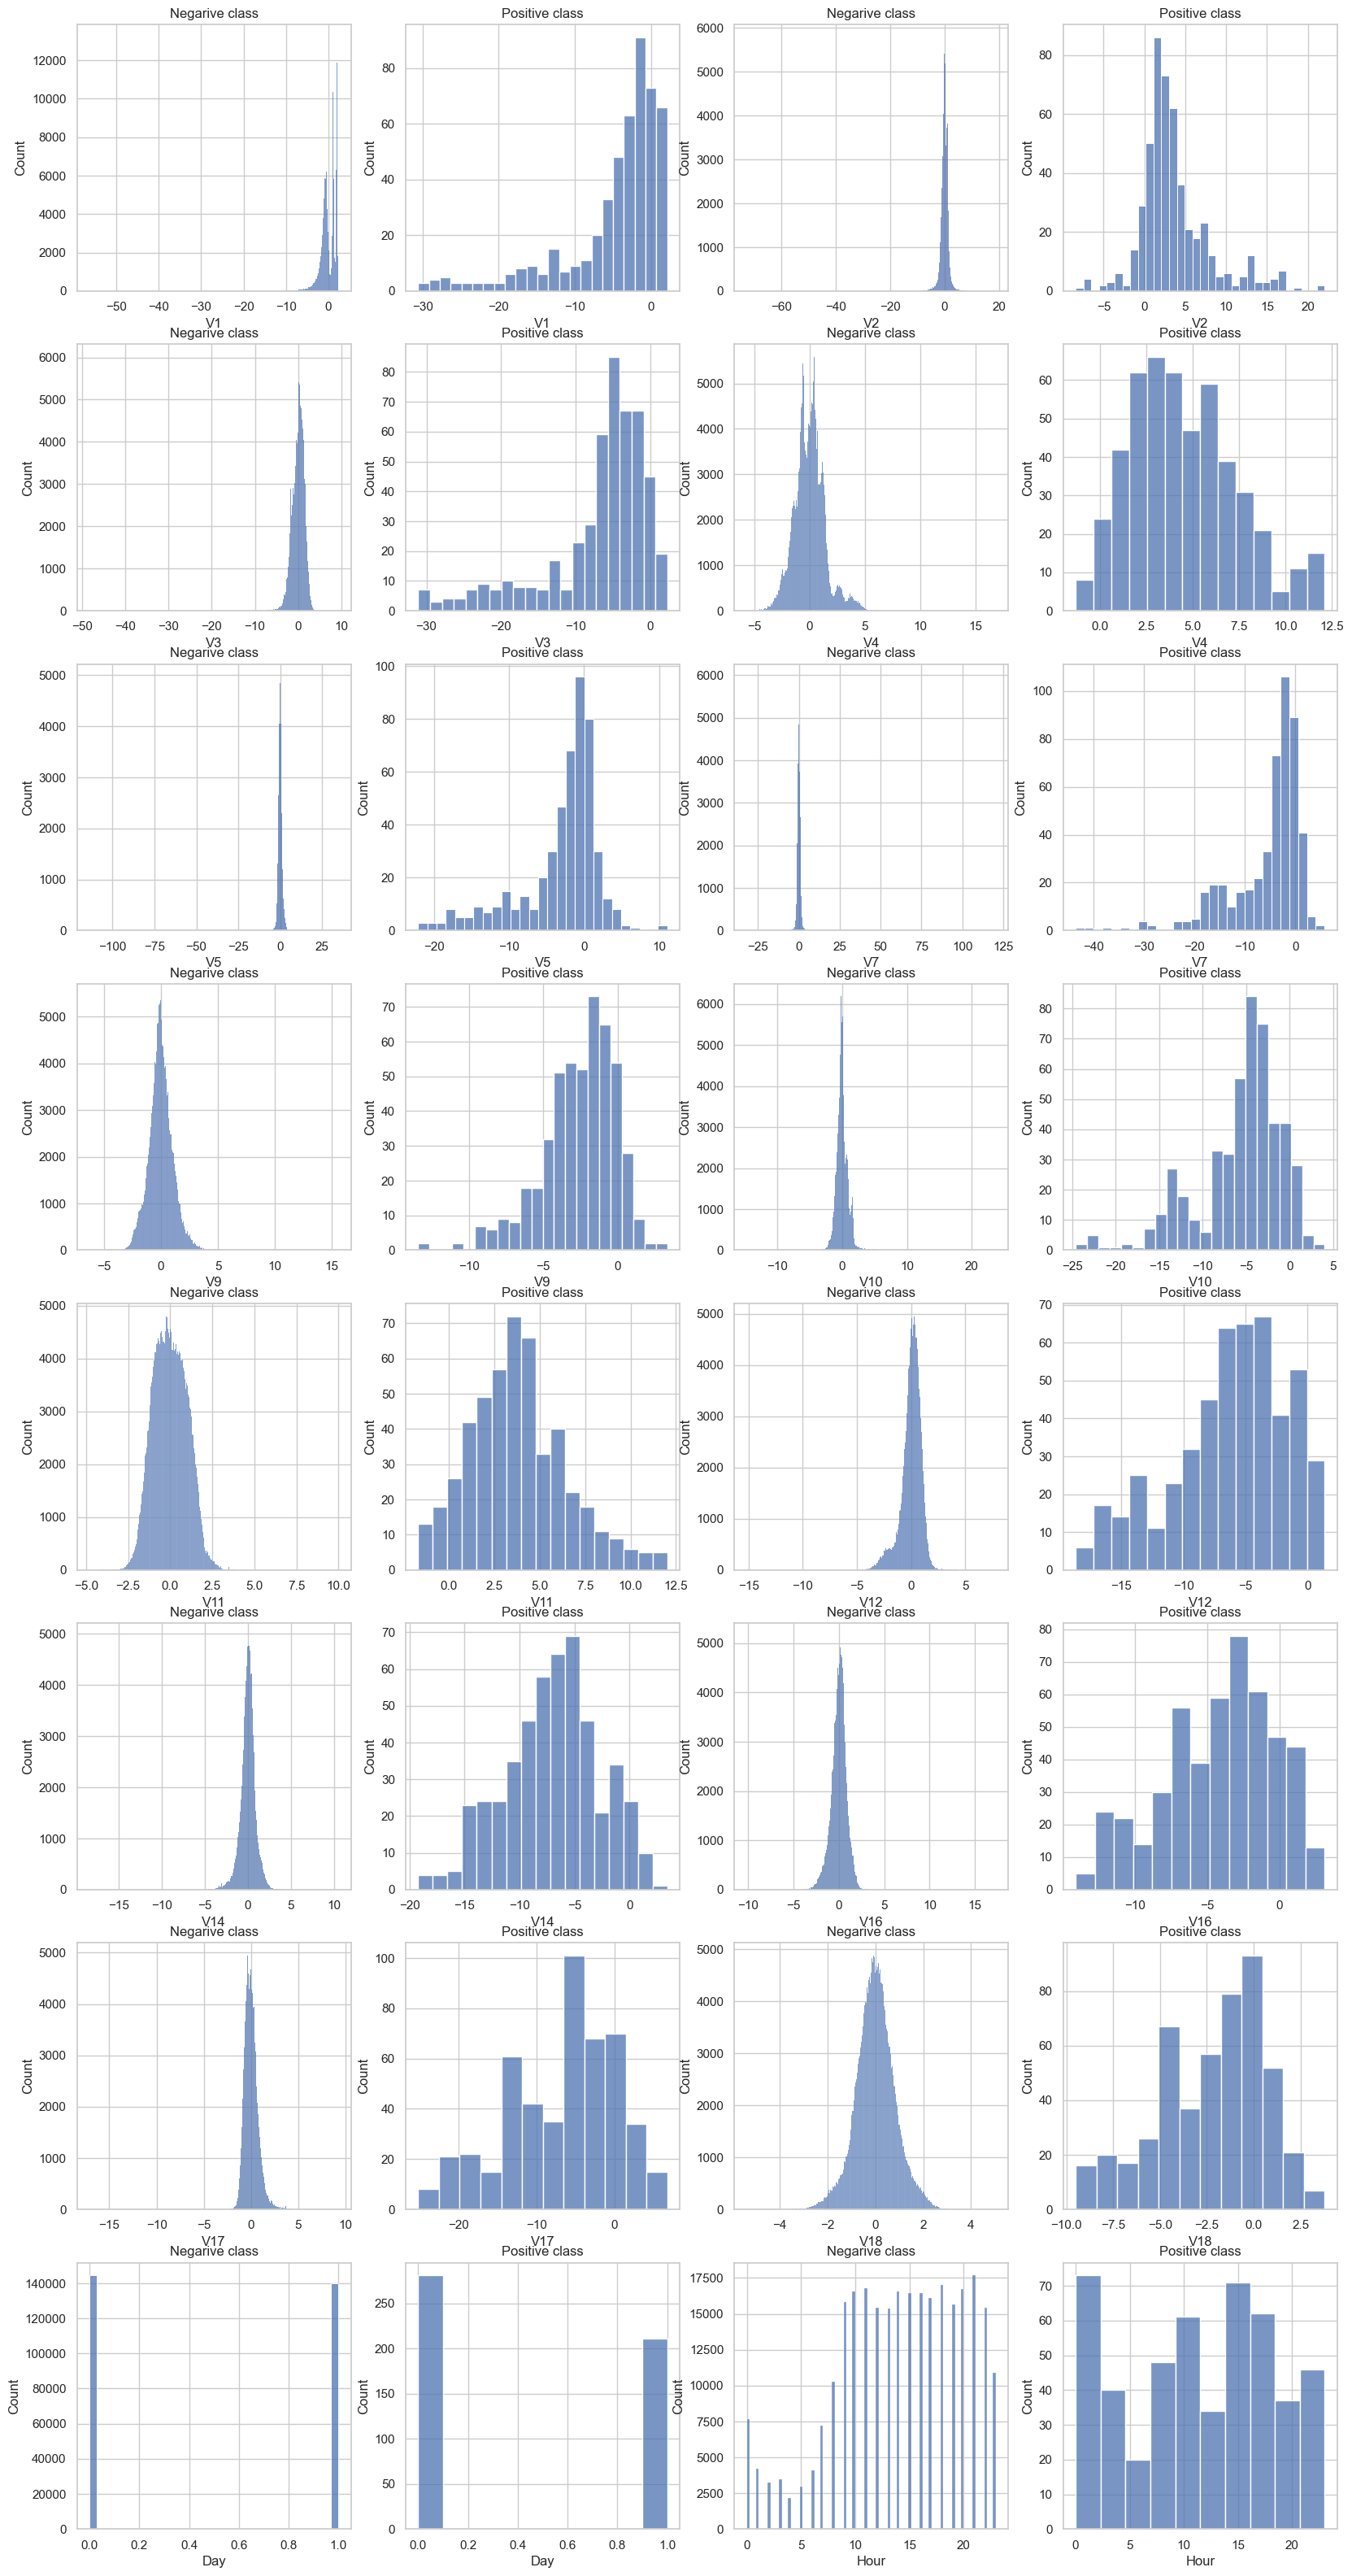

In [12]:
_, ax = plt.subplots(8, 4, figsize=(20,40))

for i in range(len(valuable_columns)*2):
    sns.histplot(data=df[df['Class'] == i%2], x=valuable_columns[i//2], ax=ax[i//4][i%4])
    pos = 'Positive class'
    neg = 'Negarive class'
    if i%2 == 0:
        ax[i//4][i%4].set_title(neg)
    else:
        ax[i//4][i%4].set_title(pos)


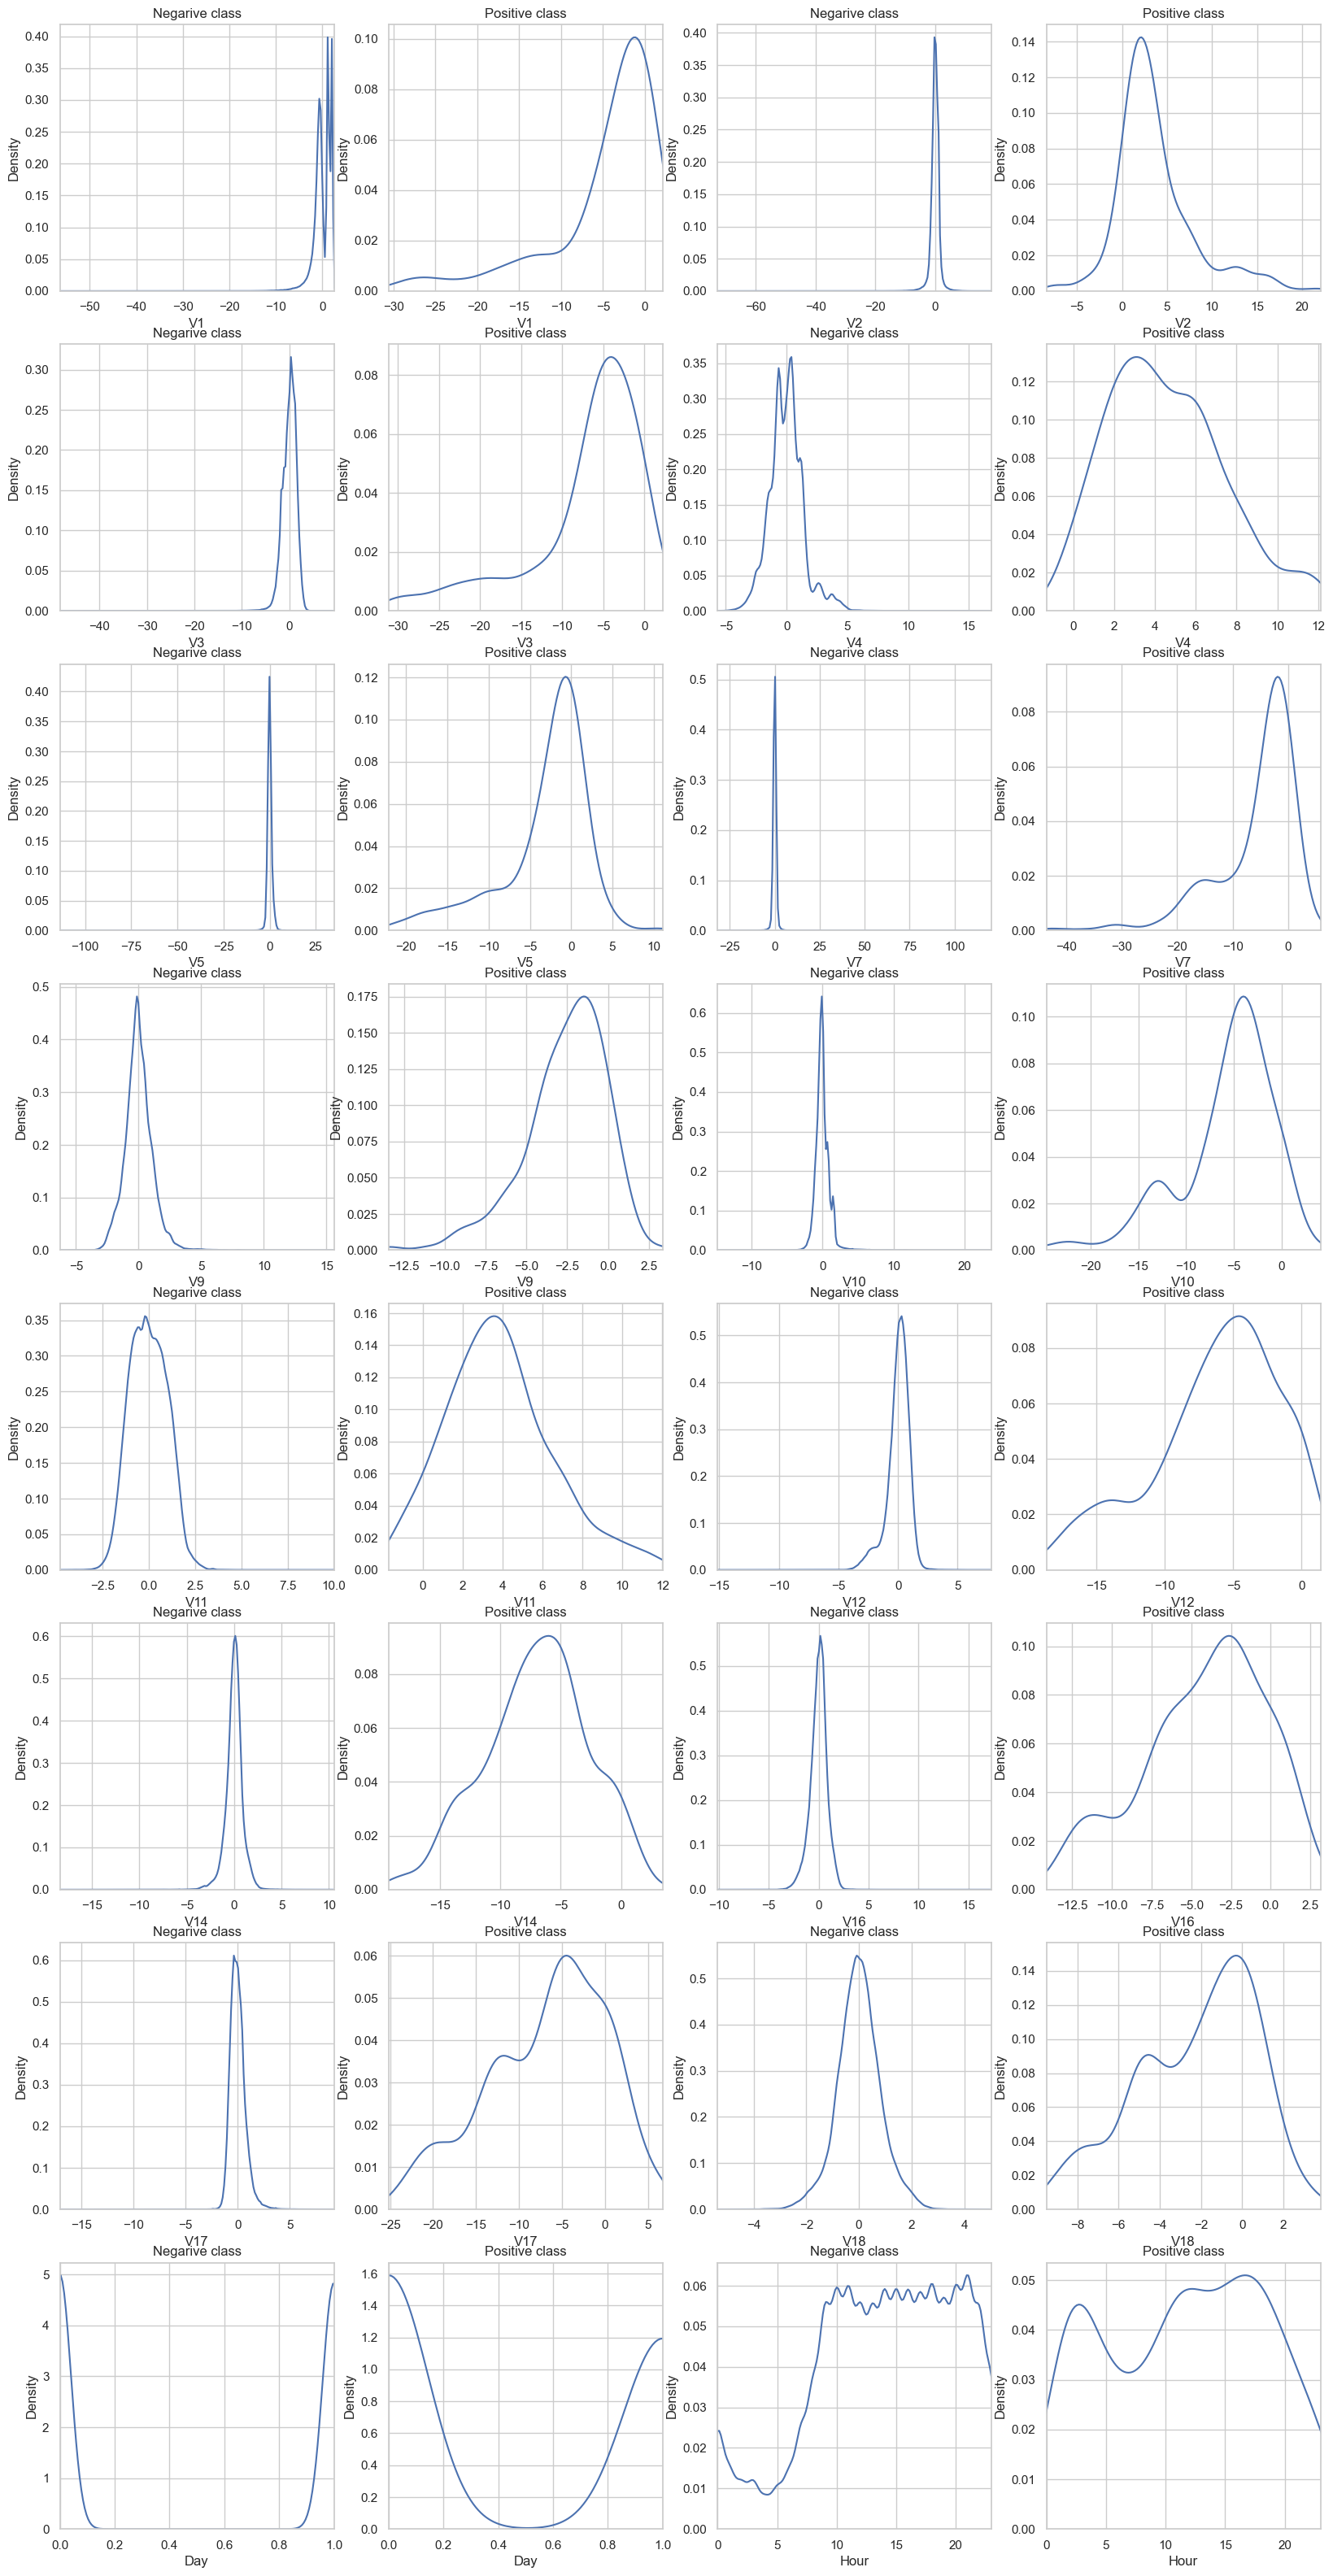

In [13]:
_, ax = plt.subplots(8, 4, figsize=(20,40))

for i in range(len(valuable_columns)*2):
    x_min = df[df['Class'] == i%2][valuable_columns[i//2]].min()
    x_max = df[df['Class'] == i%2][valuable_columns[i//2]].max()
    sns.kdeplot(data=df[df['Class'] == i%2], x=valuable_columns[i//2], ax=ax[i//4][i%4]).set(xlim=(x_min, x_max))
    pos = 'Positive class'
    neg = 'Negarive class'
    if i%2 == 0:
        ax[i//4][i%4].set_title(neg)
    else:
        ax[i//4][i%4].set_title(pos)


Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим. 

In [14]:
df.drop(['Time'], axis=1, inplace=True)

In [15]:
#your code here
X = df.iloc[:round(df.shape[0] * 0.8)]
validation = df.iloc[round(df.shape[0] * 0.8):round(df.shape[0] * 0.9)]
test = df.iloc[round(df.shape[0] * 0.9):]

# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога. 

In [16]:
#your code here
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
# Странное задание))

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

Link: 
https://en.wikipedia.org/wiki/Cohen%27s_kappa

In [17]:
#your code here

def kappa_score(y_true, y_pred, threshold=0.5):
    y_pred = np.ceil(y_pred - threshold)
    p_0 = accuracy_score(y_true, y_pred)
    p_e = (y_true[y_true==1].shape[0]/y_true.shape[0]) * (
        y_pred[y_pred==1].shape[0]/y_pred.shape[0]) + (y_true[y_true==0].shape[0]/y_true.shape[0]) * (y_pred[y_pred==0].shape[0]/y_pred.shape[0]) 
    return (p_0 - p_e) / (1 - p_e)

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом. 

Link:
http://www.machinelearning.ru/wiki/index.php?title=Корреляция_Мэтьюса

In [18]:
#your code here
def matthews_corr_score(y_true, y_pred, threshold=0.5):
    y_pred = np.ceil(y_pred - threshold)
    tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_pred).ravel()
    return (tp*tn - fp*fn) / np.sqrt( 1e-4 + (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) )

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [19]:
#your code here
naive_pred = np.zeros(df['Class'].shape[0]) + 0.1
# Добавил 0.1 чтобы проверить, работает ли пороговое значение
print(f"Kappa score: {kappa_score(df['Class'], naive_pred)} \nMatthews correlation score: {matthews_corr_score(df['Class'], naive_pred)}")

Kappa score: 0.0 
Matthews correlation score: 0.0


Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [20]:
from catboost import CatBoostClassifier

In [21]:
#your code here
cbt = CatBoostClassifier()
cbt.fit(X=X.drop(['Class'], axis=1),
        y=X['Class'],
        use_best_model=True,
        eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
        verbose=100)

Learning rate set to 0.121129
0:	learn: 0.3245748	test: 0.3305095	best: 0.3305095 (0)	total: 176ms	remaining: 2m 55s
100:	learn: 0.0013942	test: 0.0026166	best: 0.0026166 (100)	total: 1.48s	remaining: 13.2s
200:	learn: 0.0010000	test: 0.0025736	best: 0.0025552 (198)	total: 2.74s	remaining: 10.9s
300:	learn: 0.0007024	test: 0.0025288	best: 0.0025069 (258)	total: 4s	remaining: 9.29s
400:	learn: 0.0004638	test: 0.0025835	best: 0.0025069 (258)	total: 5.23s	remaining: 7.82s
500:	learn: 0.0002870	test: 0.0026914	best: 0.0025069 (258)	total: 6.53s	remaining: 6.5s
600:	learn: 0.0001890	test: 0.0027818	best: 0.0025069 (258)	total: 7.76s	remaining: 5.15s
700:	learn: 0.0001408	test: 0.0028498	best: 0.0025069 (258)	total: 9.01s	remaining: 3.84s
800:	learn: 0.0001089	test: 0.0029698	best: 0.0025069 (258)	total: 10.3s	remaining: 2.55s
900:	learn: 0.0000847	test: 0.0030685	best: 0.0025069 (258)	total: 11.5s	remaining: 1.26s
999:	learn: 0.0000694	test: 0.0031117	best: 0.0025069 (258)	total: 12.7s	rema

In [22]:
pred = cbt.predict(test.drop(['Class'], axis=1))
print(f"Kappa score: {kappa_score(test['Class'], pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)}")

Kappa score: 0.717758652842163 
Matthews correlation score: 0.7237392722838326


Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [23]:
#your code here
cbt = CatBoostClassifier(scale_pos_weight=(X[X['Class']==0].shape[0] / X[X['Class']==1].shape[0]))

cbt.fit(X=X.drop(['Class'], axis=1),
        y=X['Class'],
        use_best_model=True,
        eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
        verbose=100)

Learning rate set to 0.121129
0:	learn: 0.4605014	test: 0.4793687	best: 0.4793687 (0)	total: 15.2ms	remaining: 15.1s
100:	learn: 0.0036513	test: 0.3859621	best: 0.1485969 (21)	total: 1.44s	remaining: 12.8s
200:	learn: 0.0012271	test: 0.4973465	best: 0.1485969 (21)	total: 2.72s	remaining: 10.8s
300:	learn: 0.0012120	test: 0.4971900	best: 0.1485969 (21)	total: 3.88s	remaining: 9.01s
400:	learn: 0.0011498	test: 0.4988451	best: 0.1485969 (21)	total: 5.07s	remaining: 7.57s
500:	learn: 0.0010917	test: 0.5011968	best: 0.1485969 (21)	total: 6.21s	remaining: 6.19s
600:	learn: 0.0010912	test: 0.5012834	best: 0.1485969 (21)	total: 7.29s	remaining: 4.84s
700:	learn: 0.0010906	test: 0.5013655	best: 0.1485969 (21)	total: 8.36s	remaining: 3.56s
800:	learn: 0.0010903	test: 0.5014099	best: 0.1485969 (21)	total: 9.38s	remaining: 2.33s
900:	learn: 0.0010902	test: 0.5014374	best: 0.1485969 (21)	total: 10.5s	remaining: 1.16s
999:	learn: 0.0010899	test: 0.5014839	best: 0.1485969 (21)	total: 11.8s	remaining:

In [24]:
pred = cbt.predict(test.drop(['Class'], axis=1))
print(f"Kappa score: {kappa_score(test['Class'], pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)}")

Kappa score: 0.2040719923193742 
Matthews correlation score: 0.2935820043843665


Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части. 

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

In [25]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import make_scorer

In [26]:
def pr_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

pr_auc_scorer = make_scorer(pr_auc, greater_is_better=False)

In [27]:
#your code here
params = {
    'scale_pos_weight' : np.arange(1, 23, 2)
}

cbt = CatBoostClassifier(verbose=100)
clf = GridSearchCV(cbt, params, n_jobs=6, scoring=pr_auc_scorer)
clf.fit(X=X.drop(['Class'], axis=1), y=X['Class'])

KeyboardInterrupt: 

In [ ]:
clf.best_params_

{'scale_pos_weight': 1}

In [ ]:
cbt = CatBoostClassifier(scale_pos_weight=22)

cbt.fit(X=X.drop(['Class'], axis=1),
        y=X['Class'],
        use_best_model=True,
        eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
        verbose=100)

Learning rate set to 0.121129
0:	learn: 0.4251737	test: 0.4287275	best: 0.4287275 (0)	total: 14.2ms	remaining: 14.2s
100:	learn: 0.0037620	test: 0.0340408	best: 0.0321043 (36)	total: 1.42s	remaining: 12.6s
200:	learn: 0.0010418	test: 0.0441553	best: 0.0321043 (36)	total: 2.75s	remaining: 10.9s
300:	learn: 0.0004445	test: 0.0490739	best: 0.0321043 (36)	total: 4.06s	remaining: 9.44s
400:	learn: 0.0003017	test: 0.0531209	best: 0.0321043 (36)	total: 5.28s	remaining: 7.89s
500:	learn: 0.0002875	test: 0.0530863	best: 0.0321043 (36)	total: 6.38s	remaining: 6.35s
600:	learn: 0.0002714	test: 0.0537747	best: 0.0321043 (36)	total: 7.48s	remaining: 4.97s
700:	learn: 0.0002714	test: 0.0537752	best: 0.0321043 (36)	total: 8.53s	remaining: 3.64s
800:	learn: 0.0002714	test: 0.0537752	best: 0.0321043 (36)	total: 9.56s	remaining: 2.38s
900:	learn: 0.0002714	test: 0.0537752	best: 0.0321043 (36)	total: 10.6s	remaining: 1.16s
999:	learn: 0.0002714	test: 0.0537752	best: 0.0321043 (36)	total: 11.6s	remaining:

In [ ]:
pred = cbt.predict(test.drop(['Class'], axis=1))
print(f"Kappa score: {kappa_score(test['Class'], pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)}")

Kappa score: 0.5922192733666738 
Matthews correlation score: 0.6026624192123663


In [ ]:
pred = cbt.predict_proba(test.drop(['Class'], axis=1)).T[1].T
print(f"Kappa score: {kappa_score(test['Class'], pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)}")

Kappa score: 0.5922192733666738 
Matthews correlation score: 0.6026624192123663


In [ ]:
for element in np.arange(0, 1, 0.05):
    print(element)
    print(f"Kappa score: {kappa_score(test['Class'], pred, element)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred, element)}")

0.0
Kappa score: 0.0 
Matthews correlation score: 0.0
0.05
Kappa score: 0.1727878906465009 
Matthews correlation score: 0.2667765325045401
0.1
Kappa score: 0.3160051581825231 
Matthews correlation score: 0.38300682110734446
0.15000000000000002
Kappa score: 0.3628981746599957 
Matthews correlation score: 0.4192009356583289
0.2
Kappa score: 0.42041643156445446 
Matthews correlation score: 0.46361553382418874
0.25
Kappa score: 0.4501179458365336 
Matthews correlation score: 0.4867699092937536
0.30000000000000004
Kappa score: 0.48431736970194456 
Matthews correlation score: 0.513762393318687
0.35000000000000003
Kappa score: 0.5156462754710843 
Matthews correlation score: 0.5389049208949828
0.4
Kappa score: 0.5241201296363234 
Matthews correlation score: 0.5457870330812422
0.45
Kappa score: 0.5814301953414529 
Matthews correlation score: 0.5934426606164669
0.5
Kappa score: 0.5922192733666738 
Matthews correlation score: 0.6026624192123663
0.55
Kappa score: 0.603415225090152 
Matthews correl

In [ ]:
for element in np.arange(0.95, 1, 0.005):
    print(element)
    print(f"Kappa score: {kappa_score(test['Class'], pred, element)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred, element)}")

0.95
Kappa score: 0.7025163867568979 
Matthews correlation score: 0.7154533543541229
0.955
Kappa score: 0.7025163867568979 
Matthews correlation score: 0.7154533543541229
0.96
Kappa score: 0.7220552356787183 
Matthews correlation score: 0.740595613158736
0.965
Kappa score: 0.7057218962912748 
Matthews correlation score: 0.7384192234036915
0.97
Kappa score: 0.7057218962912748 
Matthews correlation score: 0.7384192234036915
0.975
Kappa score: 0.7057218962912748 
Matthews correlation score: 0.7384192234036915
0.98
Kappa score: 0.6248188708077065 
Matthews correlation score: 0.6740577661017235
0.985
Kappa score: 0.6248188708077065 
Matthews correlation score: 0.6740577661017235
0.99
Kappa score: 0.4825656671604613 
Matthews correlation score: 0.5639274786293047
0.995
Kappa score: 0.0 
Matthews correlation score: 0.0
1.0
Kappa score: 0.0 
Matthews correlation score: 0.0


In [ ]:
cbt = CatBoostClassifier(scale_pos_weight=1)

cbt.fit(X=X.drop(['Class'], axis=1),
        y=X['Class'],
        use_best_model=True,
        eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
        verbose=100)

Learning rate set to 0.121129
0:	learn: 0.3245748	test: 0.3305095	best: 0.3305095 (0)	total: 14.6ms	remaining: 14.6s
100:	learn: 0.0013942	test: 0.0026166	best: 0.0026166 (100)	total: 1.32s	remaining: 11.8s
200:	learn: 0.0010000	test: 0.0025736	best: 0.0025552 (198)	total: 2.63s	remaining: 10.5s
300:	learn: 0.0007024	test: 0.0025288	best: 0.0025069 (258)	total: 3.94s	remaining: 9.14s
400:	learn: 0.0004638	test: 0.0025835	best: 0.0025069 (258)	total: 5.25s	remaining: 7.85s
500:	learn: 0.0002870	test: 0.0026914	best: 0.0025069 (258)	total: 6.6s	remaining: 6.57s
600:	learn: 0.0001890	test: 0.0027818	best: 0.0025069 (258)	total: 7.99s	remaining: 5.3s
700:	learn: 0.0001408	test: 0.0028498	best: 0.0025069 (258)	total: 9.36s	remaining: 3.99s
800:	learn: 0.0001089	test: 0.0029698	best: 0.0025069 (258)	total: 10.8s	remaining: 2.68s
900:	learn: 0.0000847	test: 0.0030685	best: 0.0025069 (258)	total: 12s	remaining: 1.32s
999:	learn: 0.0000694	test: 0.0031117	best: 0.0025069 (258)	total: 13.2s	rema

In [ ]:
pred = cbt.predict_proba(test.drop(['Class'], axis=1)).T[1].T

In [ ]:
for element in np.arange(0, 1, 0.05):
    print(element)
    print(f"Kappa score: {kappa_score(test['Class'], pred, element)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred, element)}")

0.0
Kappa score: 0.0 
Matthews correlation score: 0.0
0.05
Kappa score: 0.5609870538888099 
Matthews correlation score: 0.5762022835947604
0.1
Kappa score: 0.5765456595020853 
Matthews correlation score: 0.5835048680509853
0.15000000000000002
Kappa score: 0.6974461474849205 
Matthews correlation score: 0.6976351100712621
0.2
Kappa score: 0.6974461474849205 
Matthews correlation score: 0.6976351100712621
0.25
Kappa score: 0.7140753704859292 
Matthews correlation score: 0.7148875558265598
0.30000000000000004
Kappa score: 0.6826996662053398 
Matthews correlation score: 0.6845372504507212
0.35000000000000003
Kappa score: 0.6826996662053398 
Matthews correlation score: 0.6845372504507212
0.4
Kappa score: 0.6826996662053398 
Matthews correlation score: 0.6845372504507212
0.45
Kappa score: 0.6826996662053398 
Matthews correlation score: 0.6845372504507212
0.5
Kappa score: 0.717758652842163 
Matthews correlation score: 0.7237392722838326
0.55
Kappa score: 0.717758652842163 
Matthews correlatio

**Наиболее оптимальные параметры для метрик**

scale_pos_weight = 22

- threshold = 0.96

- Kappa score: 0.7220552356787183 

- Matthews correlation score: 0.740595613158736

scale_pos_weight = 1

- threshold = 0.5

- Kappa score: 0.717758652842163 

- Matthews correlation score: 0.7237392722838326

Как это интерпретировать? Мы смотрим на вероятность принадлежности к минорному классу. Соответственно, мы хотим, чтобы вероятность принадлежности к такому классу была максимальная 

In [ ]:
# ПОШАЛИМ!!!

cbt = CatBoostClassifier(scale_pos_weight=0.01)

cbt.fit(X=X.drop(['Class'], axis=1),
        y=X['Class'],
        use_best_model=True,
        eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
        verbose=10000)

pred = cbt.predict(test.drop(['Class'], axis=1))
print("scale_pos_weight = 0.01")
print(f"Kappa score: {kappa_score(test['Class'], pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)}")

cbt = CatBoostClassifier(scale_pos_weight=900)

cbt.fit(X=X.drop(['Class'], axis=1),
        y=X['Class'],
        use_best_model=True,
        eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
        verbose=10000)

pred = cbt.predict(test.drop(['Class'], axis=1))
print('scale_pos_weight = 900')
print(f"Kappa score: {kappa_score(test['Class'], pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)}")

Learning rate set to 0.121129
0:	learn: 0.2864574	test: 0.2885895	best: 0.2885895 (0)	total: 15.7ms	remaining: 15.6s
999:	learn: 0.0000345	test: 0.0000558	best: 0.0000555 (862)	total: 17.1s	remaining: 0us

bestTest = 5.545641918e-05
bestIteration = 862

Shrink model to first 863 iterations.
scale_pos_weight = 0.01
Kappa score: 0.6664949238281258 
Matthews correlation score: 0.7069701649931032
Learning rate set to 0.121129
0:	learn: 0.4690213	test: 0.5009908	best: 0.5009908 (0)	total: 18.4ms	remaining: 18.4s
999:	learn: 0.0012479	test: 0.7046486	best: 0.1696636 (15)	total: 14.8s	remaining: 0us

bestTest = 0.1696636261
bestIteration = 15

Shrink model to first 16 iterations.
scale_pos_weight = 900
Kappa score: 0.06916702133604043 
Matthews correlation score: 0.16687399942030703


**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса. 

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

In [ ]:
!pip3 install imbalanced-learn

   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/258.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/258.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/258.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/258.0 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/258.0 kB 109.5 kB/s eta 0:00:03
   ------ -------------------------------- 41.0/258.0 kB 131.3 kB/s eta 0:00:02
   ------------ -------------------------- 81.9/258.0 kB 255.1 kB/s eta 0:00:01
   ------------- ------------------------- 92.2/258.0 kB 249.8 kB/s eta 0:00:01
   ------------- ------------------------- 92.2/258.0 kB 249.8 kB/s eta 0:00:01
   ------------------------ 

Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку. 

In [ ]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).



In [ ]:
# your code here
# sampling 1:1
sm_1_1 = SMOTE(random_state=42)
X_res_1_1, y_res_1_1 = sm_1_1.fit_resample(X=X.drop(['Class'], axis=1), y=X['Class'])

# sampling 1:2
sm_1_2 = SMOTE(sampling_strategy=0.5 ,random_state=42)
X_res_1_2, y_res_1_2 = sm_1_2.fit_resample(X=X.drop(['Class'], axis=1), y=X['Class'])

# sampling 1:10
sm_1_10 = SMOTE(sampling_strategy=0.1 ,random_state=42)
X_res_1_10, y_res_1_10 = sm_1_10.fit_resample(X=X.drop(['Class'], axis=1), y=X['Class'])

sm_1_20 = SMOTE(sampling_strategy=0.05 ,random_state=42)
X_res_1_20, y_res_1_20 = sm_1_20.fit_resample(X=X.drop(['Class'], axis=1), y=X['Class'])

In [ ]:
(y_res_1_20==1).sum()

2274

In [ ]:
cbt = CatBoostClassifier()
cbt.fit(X=X_res_1_1,
        y=y_res_1_1,
        use_best_model=True,
        eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
        verbose=1000)

pred = cbt.predict(test.drop(['Class'], axis=1))
print("Score on 1:1")
print(f"Kappa score: {kappa_score(test['Class'], pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)}")

Learning rate set to 0.143683
0:	learn: 0.4308677	test: 0.4113606	best: 0.4113606 (0)	total: 40ms	remaining: 40s
999:	learn: 0.0031874	test: 0.0045044	best: 0.0045044 (999)	total: 28s	remaining: 0us

bestTest = 0.004504368116
bestIteration = 999

Score on 1:1
Kappa score: 0.6150415086382593 
Matthews correlation score: 0.6224653822800065


In [ ]:
cbt = CatBoostClassifier()
cbt.fit(X=X_res_1_2,
        y=y_res_1_2,
        use_best_model=True,
        eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
        verbose=1000)

pred = cbt.predict(test.drop(['Class'], axis=1))
print("Score on 1:2")
print(f"Kappa score: {kappa_score(test['Class'], pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)}")

Learning rate set to 0.133827
0:	learn: 0.4507298	test: 0.4690003	best: 0.4690003 (0)	total: 80.3ms	remaining: 1m 20s
999:	learn: 0.0015822	test: 0.0031520	best: 0.0031399 (712)	total: 42.1s	remaining: 0us

bestTest = 0.003139897867
bestIteration = 712

Shrink model to first 713 iterations.
Score on 1:2
Kappa score: 0.6518933288517552 
Matthews correlation score: 0.6525113573742592


In [ ]:
cbt = CatBoostClassifier()
cbt.fit(X=X_res_1_10,
        y=y_res_1_10,
        use_best_model=True,
        eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
        verbose=1000)

pred = cbt.predict(test.drop(['Class'], axis=1))
print("Score on 1:10")
print(f"Kappa score: {kappa_score(test['Class'], pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)}")

Learning rate set to 0.123958
0:	learn: 0.4433078	test: 0.4473797	best: 0.4473797 (0)	total: 64.2ms	remaining: 1m 4s
999:	learn: 0.0008720	test: 0.0028719	best: 0.0028505 (311)	total: 25.7s	remaining: 0us

bestTest = 0.002850481612
bestIteration = 311

Shrink model to first 312 iterations.
Score on 1:10
Kappa score: 0.7108828212297992 
Matthews correlation score: 0.7110586906187202


In [ ]:
cbt = CatBoostClassifier()
cbt.fit(X=X_res_1_20,
        y=y_res_1_20,
        use_best_model=True,
        eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
        verbose=1000)

pred = cbt.predict(test.drop(['Class'], axis=1))
print("Score on 1:20")
print(f"Kappa score: {kappa_score(test['Class'], pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)}")

Learning rate set to 0.122542
0:	learn: 0.4176271	test: 0.4118863	best: 0.4118863 (0)	total: 60.1ms	remaining: 60s
999:	learn: 0.0004336	test: 0.0031054	best: 0.0029121 (215)	total: 32.5s	remaining: 0us

bestTest = 0.002912114555
bestIteration = 215

Shrink model to first 216 iterations.
Score on 1:20
Kappa score: 0.7803305381421584 
Matthews correlation score: 0.782430909907469


Уже интересно, чем меньше синтетических данных, тем лучше. Надо попробовать посоздавать выборки с разным отношением и посравнивать

In [ ]:
for ss in np.arange(0.01, 0.055, 0.005):
    sm = SMOTE(sampling_strategy=ss ,random_state=42)
    X_res, y_res = sm.fit_resample(X=X.drop(['Class'], axis=1), y=X['Class'])
    cbt = CatBoostClassifier()
    cbt.fit(X=X_res,
        y=y_res,
        use_best_model=True,
        eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
        verbose=False)

    pred = cbt.predict(test.drop(['Class'], axis=1))
    print(f"Score on {ss} \n")
    print(f"Kappa score: {kappa_score(test['Class'], pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)} \n")

Score on 0.01 

Kappa score: 0.7270618976582063 
Matthews correlation score: 0.727061897658194 

Score on 0.015 

Kappa score: 0.743992894025702 
Matthews correlation score: 0.7441944677557767 

Score on 0.019999999999999997 

Kappa score: 0.7803305381421584 
Matthews correlation score: 0.782430909907469 

Score on 0.024999999999999998 

Kappa score: 0.7270618976582063 
Matthews correlation score: 0.727061897658194 

Score on 0.03 

Kappa score: 0.6974461474849205 
Matthews correlation score: 0.6976351100712621 

Score on 0.034999999999999996 

Kappa score: 0.761729475404941 
Matthews correlation score: 0.7625958622585117 

Score on 0.039999999999999994 

Kappa score: 0.761729475404941 
Matthews correlation score: 0.7625958622585117 

Score on 0.045 

Kappa score: 0.7270618976582063 
Matthews correlation score: 0.727061897658194 

Score on 0.049999999999999996 

Kappa score: 0.7803305381421584 
Matthews correlation score: 0.782430909907469 



**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять):

BorderlineSMOTE - 

SVM-SMOTE - 

K-Means-SMOTE - 

ADASYN - 

Теперь попробуйте сравнить качество всех методов на наших данных.

1. BorderlineSMOTE

- BorderlineSMOTE фокусируется на пограничных примерах меньшинства, которые наиболее вероятно будут неправильно классифицированы. Генерирует синтетические примеры только для этих пограничных случаев.

2. SVM-SMOTE

- SVM-SMOTE сочетает SVM с SMOTE для создания синтетических образцов. Использует опорные векторы, определенные SVM, для улучшения качества синтетических примеров.
- Признаки создаются на основе опорных векторов SVM классифаера, обученного на выборке


3. K-Means-SMOTE

- K-Means-SMOTE объединяет кластеризацию K-Means с SMOTE для создания синтетических образцов. Генерирует синтетические примеры внутри кластеров.

4. ADASYN

- ADASYN адаптирует количество синтетических образцов для разных примеров класса меньшинства в зависимости от сложности их обучения.

- Для каждого минорного класса находится количество синтетических образцов, основываясь на плотности (количестве соседей мажорного класса). Далее SMOTE генерирует новые объекты для классов, которые наиболее трудны для модели с точки зрения обучения. 

In [ ]:
# your code here

**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# your code here
# sampling_strategy = N_minority / N_majority_after_resempling

RUS_1_10 = RandomUnderSampler(sampling_strategy=0.005, random_state=42)
X_res_0_8, y_res_0_8 = RUS_1_10.fit_resample(X=X.drop(['Class'], axis=1), y=X['Class'])


In [ ]:
X_res_0_8.shape

(83817, 31)

In [ ]:
cbt = CatBoostClassifier()
cbt.fit(X=X_res_0_8,
    y=y_res_0_8,
    use_best_model=True,
    eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
    verbose=False)

pred = cbt.predict(test.drop(['Class'], axis=1))
print("Score on sampling_strategy = 0.005 \n")
print(f"Kappa score: {kappa_score(test['Class'], pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)} \n")

Score on sampling_strategy = 0.005 

Kappa score: 0.761729475404941 
Matthews correlation score: 0.7625958622585117 



Ну, пойдет

Попробуем перебрать

In [ ]:
kappa_metric_score_array = []
matthews_corr_metric_score_array = []
sampler_score_array = []

In [ ]:
for score in np.arange(0.002, 0.01, 0.0005):
    
    RUS = RandomUnderSampler(sampling_strategy=score, random_state=42)
    X_res, y_res = RUS.fit_resample(X=X.drop(['Class'], axis=1), y=X['Class'])

    cbt = CatBoostClassifier()
    cbt.fit(X=X_res,
        y=y_res,
        use_best_model=True,
        eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
        verbose=False)

    pred = cbt.predict(test.drop(['Class'], axis=1))
    
    sampler_score_array.append(score)
    kappa_metric_score_array.append( kappa_score(test['Class'], pred) )
    matthews_corr_metric_score_array.append( matthews_corr_score(test['Class'], pred) )

    print(f"Score on sampling_strategy = {score} \n")
    print(f"Kappa score: {kappa_score(test['Class'], pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)} \n")

Score on sampling_strategy = 0.002 

Kappa score: 0.6840049779303293 
Matthews correlation score: 0.6927057007478311 

Score on sampling_strategy = 0.0025 

Kappa score: 0.7690752614163152 
Matthews correlation score: 0.7754834690252621 

Score on sampling_strategy = 0.003 

Kappa score: 0.7140753704859292 
Matthews correlation score: 0.7148875558265598 

Score on sampling_strategy = 0.0035 

Kappa score: 0.6974461474849205 
Matthews correlation score: 0.6976351100712621 

Score on sampling_strategy = 0.004 

Kappa score: 0.7998608632102646 
Matthews correlation score: 0.8038960655235944 

Score on sampling_strategy = 0.0045000000000000005 

Kappa score: 0.7270618976582063 
Matthews correlation score: 0.727061897658194 

Score on sampling_strategy = 0.005 

Kappa score: 0.761729475404941 
Matthews correlation score: 0.7625958622585117 

Score on sampling_strategy = 0.0055 

Kappa score: 0.7140753704859292 
Matthews correlation score: 0.7148875558265598 

Score on sampling_strategy = 0.

Score on sampling_strategy = 0.004 

Kappa score: 0.7998608632102646 

Matthews correlation score: 0.8038960655235944 

In [ ]:
kappa_metric_score_array = np.array(kappa_metric_score_array)
matthews_corr_metric_score_array = np.array(matthews_corr_metric_score_array)
sampler_score_array = np.array(sampler_score_array)

# sampler_score_array[np.newaxis, :].T

<Axes: xlabel='s_strategy', ylabel='value'>

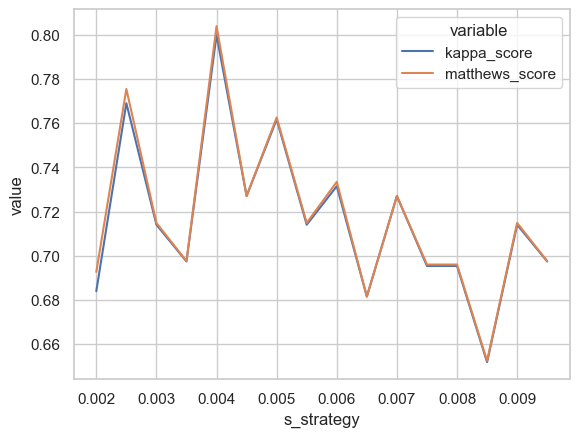

In [ ]:
undersample_df = pd.DataFrame(data=sampler_score_array, columns=['s_strategy'])
undersample_df['kappa_score'] = kappa_metric_score_array
undersample_df['matthews_score'] = matthews_corr_metric_score_array

undersample_df = pd.melt(undersample_df, id_vars='s_strategy', value_vars=['kappa_score', 'matthews_score'])
sns.lineplot( data=undersample_df, 
             x='s_strategy', 
             y='value', 
             hue='variable' )

Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [ ]:
kappa_metric_score_array = []
matthews_corr_metric_score_array = []
sampler_score_array = []

In [ ]:
from imblearn.under_sampling import NearMiss

# your code here

for score in np.arange(0.002, 0.01, 0.0003):
    
    NS = NearMiss(sampling_strategy=score)
    X_res, y_res = NS.fit_resample(X=X.drop(['Class'], axis=1), y=X['Class'])

    cbt = CatBoostClassifier()
    cbt.fit(X=X_res,
        y=y_res,
        use_best_model=True,
        eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
        verbose=False)

    pred = cbt.predict(test.drop(['Class'], axis=1))
    
    sampler_score_array.append(score)
    kappa_metric_score_array.append( kappa_score(test['Class'], pred) )
    matthews_corr_metric_score_array.append( matthews_corr_score(test['Class'], pred) )

    print(f"Score on sampling_strategy = {score} \n")
    print(f"Kappa score: {kappa_score(test['Class'], pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)} \n")

Score on sampling_strategy = 0.002 

Kappa score: 0.6974461474849205 
Matthews correlation score: 0.6976351100712621 

Score on sampling_strategy = 0.0023 

Kappa score: 0.761729475404941 
Matthews correlation score: 0.7625958622585117 

Score on sampling_strategy = 0.0026 

Kappa score: 0.681572213934574 
Matthews correlation score: 0.6815722139345597 

Score on sampling_strategy = 0.0029 

Kappa score: 0.789336651953553 
Matthews correlation score: 0.7993772213060291 

Score on sampling_strategy = 0.0031999999999999997 

Kappa score: 0.7498260790128308 
Matthews correlation score: 0.753608861828937 

Score on sampling_strategy = 0.0034999999999999996 

Kappa score: 0.6826996662053398 
Matthews correlation score: 0.6845372504507212 

Score on sampling_strategy = 0.0037999999999999996 

Kappa score: 0.717758652842163 
Matthews correlation score: 0.7237392722838326 

Score on sampling_strategy = 0.0040999999999999995 

Kappa score: 0.7220552356787183 
Matthews correlation score: 0.74059

In [ ]:
kappa_metric_score_array = np.array(kappa_metric_score_array)
matthews_corr_metric_score_array = np.array(matthews_corr_metric_score_array)
sampler_score_array = np.array(sampler_score_array)

<Axes: xlabel='s_strategy', ylabel='value'>

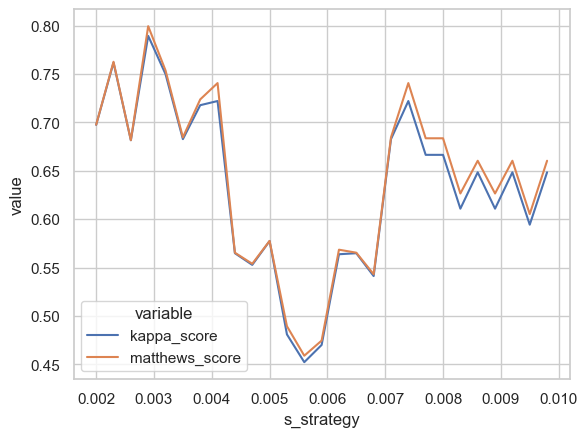

In [ ]:
undersample_df = pd.DataFrame(data=sampler_score_array, columns=['s_strategy'])
undersample_df['kappa_score'] = kappa_metric_score_array
undersample_df['matthews_score'] = matthews_corr_metric_score_array

undersample_df = pd.melt(undersample_df, id_vars='s_strategy', value_vars=['kappa_score', 'matthews_score'])
sns.lineplot( data=undersample_df, 
             x='s_strategy', 
             y='value', 
             hue='variable' )

In [ ]:
kappa_metric_score_array = []
matthews_corr_metric_score_array = []
sampler_score_array = []

In [ ]:
for score in np.arange(0.002, 0.1, 0.01):
    
    NS = NearMiss(sampling_strategy=score)
    X_res, y_res = NS.fit_resample(X=X.drop(['Class'], axis=1), y=X['Class'])

    cbt = CatBoostClassifier()
    cbt.fit(X=X_res,
        y=y_res,
        use_best_model=True,
        eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
        verbose=False)

    pred = cbt.predict(test.drop(['Class'], axis=1))
    
    sampler_score_array.append(score)
    kappa_metric_score_array.append( kappa_score(test['Class'], pred) )
    matthews_corr_metric_score_array.append( matthews_corr_score(test['Class'], pred) )

    print(f"Score on sampling_strategy = {score} \n")
    print(f"Kappa score: {kappa_score(test['Class'], pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)} \n")

Score on sampling_strategy = 0.002 

Kappa score: 0.6974461474849205 
Matthews correlation score: 0.6976351100712621 

Score on sampling_strategy = 0.012 

Kappa score: 0.49010528940168374 
Matthews correlation score: 0.49734155116780154 

Score on sampling_strategy = 0.022 

Kappa score: 0.0712808850474802 
Matthews correlation score: 0.15963470155603168 

Score on sampling_strategy = 0.032 

Kappa score: 0.3252938668150436 
Matthews correlation score: 0.3814737919629423 

Score on sampling_strategy = 0.042 

Kappa score: 0.030278692957069205 
Matthews correlation score: 0.10863169149711675 

Score on sampling_strategy = 0.052000000000000005 

Kappa score: 0.005908762804551053 
Matthews correlation score: 0.04488731883285088 

Score on sampling_strategy = 0.062 

Kappa score: 0.015912420374824085 
Matthews correlation score: 0.08038443590862687 

Score on sampling_strategy = 0.07200000000000001 

Kappa score: 0.005693378886438232 
Matthews correlation score: 0.04400293654224996 

Scor

<Axes: xlabel='s_strategy', ylabel='value'>

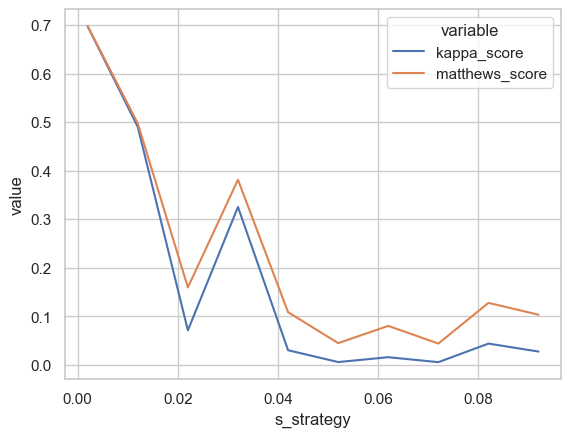

In [ ]:
kappa_metric_score_array = np.array(kappa_metric_score_array)
matthews_corr_metric_score_array = np.array(matthews_corr_metric_score_array)
sampler_score_array = np.array(sampler_score_array)

undersample_df = pd.DataFrame(data=sampler_score_array, columns=['s_strategy'])
undersample_df['kappa_score'] = kappa_metric_score_array
undersample_df['matthews_score'] = matthews_corr_metric_score_array

undersample_df = pd.melt(undersample_df, id_vars='s_strategy', value_vars=['kappa_score', 'matthews_score'])
sns.lineplot( data=undersample_df, 
             x='s_strategy', 
             y='value', 
             hue='variable' )

Score on sampling_strategy = 1 

Kappa score: 0.5486230882924985 
Matthews correlation score: 0.5538743542256439 

Score on sampling_strategy = 2 

Kappa score: 0.6974461474849205 
Matthews correlation score: 0.6976351100712621 

Score on sampling_strategy = 3 

Kappa score: 0.666466282814462 
Matthews correlation score: 0.6835792900340176 

Score on sampling_strategy = 4 

Kappa score: 0.6484284570763339 
Matthews correlation score: 0.6603693855677545 

Score on sampling_strategy = 5 

Kappa score: 0.5552883770859492 
Matthews correlation score: 0.5695466437845808 



<Axes: xlabel='n_neighbours', ylabel='value'>

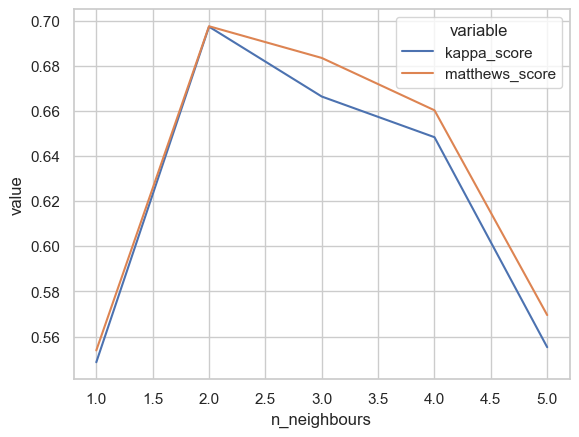

In [ ]:
kappa_metric_score_array = []
matthews_corr_metric_score_array = []
sampler_score_array = []

for i in range(1, 6):
    
    NS = NearMiss(sampling_strategy=0.008, n_neighbors=i)
    X_res, y_res = NS.fit_resample(X=X.drop(['Class'], axis=1), y=X['Class'])

    cbt = CatBoostClassifier()
    cbt.fit(X=X_res,
        y=y_res,
        use_best_model=True,
        eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
        verbose=False)

    pred = cbt.predict(test.drop(['Class'], axis=1))
    
    sampler_score_array.append(i)
    kappa_metric_score_array.append( kappa_score(test['Class'], pred) )
    matthews_corr_metric_score_array.append( matthews_corr_score(test['Class'], pred) )

    print(f"Score on sampling_strategy = {i} \n")
    print(f"Kappa score: {kappa_score(test['Class'], pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)} \n")  


kappa_metric_score_array = np.array(kappa_metric_score_array)
matthews_corr_metric_score_array = np.array(matthews_corr_metric_score_array)
sampler_score_array = np.array(sampler_score_array)

undersample_df = pd.DataFrame(data=sampler_score_array, columns=['n_neighbours'])
undersample_df['kappa_score'] = kappa_metric_score_array
undersample_df['matthews_score'] = matthews_corr_metric_score_array

undersample_df = pd.melt(undersample_df, id_vars='n_neighbours', value_vars=['kappa_score', 'matthews_score'])
sns.lineplot( data=undersample_df, 
             x='n_neighbours', 
             y='value', 
             hue='variable' )

**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.

Link: https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.NeighbourhoodCleaningRule.html#imblearn.under_sampling.NeighbourhoodCleaningRule


Данный алгоритм в своей работе очень схож с Condensed nearest neighbors, однако количество ближайших соседей для kNN можно подбирать

Score on sampling_strategy = 1 

Kappa score: 0.6664212655669174 
Matthews correlation score: 0.667179249394608 

Score on sampling_strategy = 2 

Kappa score: 0.7690752614163152 
Matthews correlation score: 0.7754834690252621 

Score on sampling_strategy = 3 

Kappa score: 0.7140753704859292 
Matthews correlation score: 0.7148875558265598 

Score on sampling_strategy = 4 

Kappa score: 0.7140753704859292 
Matthews correlation score: 0.7148875558265598 

Score on sampling_strategy = 5 

Kappa score: 0.7498260790128308 
Matthews correlation score: 0.753608861828937 



<Axes: xlabel='n_neighbours', ylabel='value'>

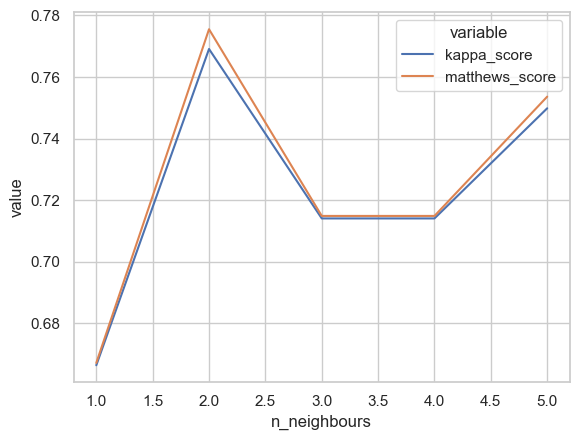

In [ ]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

kappa_metric_score_array = []
matthews_corr_metric_score_array = []
sampler_score_array = []

for i in range(1, 6):
    
    NS = NeighbourhoodCleaningRule(n_neighbors=i)
    X_res, y_res = NS.fit_resample(X=X.drop(['Class'], axis=1), y=X['Class'])

    cbt = CatBoostClassifier()
    cbt.fit(X=X_res,
        y=y_res,
        use_best_model=True,
        eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
        verbose=False)

    pred = cbt.predict(test.drop(['Class'], axis=1))
    
    sampler_score_array.append(i)
    kappa_metric_score_array.append( kappa_score(test['Class'], pred) )
    matthews_corr_metric_score_array.append( matthews_corr_score(test['Class'], pred) )

    print(f"Score on sampling_strategy = {i} \n")
    print(f"Kappa score: {kappa_score(test['Class'], pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)} \n")  


kappa_metric_score_array = np.array(kappa_metric_score_array)
matthews_corr_metric_score_array = np.array(matthews_corr_metric_score_array)
sampler_score_array = np.array(sampler_score_array)

undersample_df = pd.DataFrame(data=sampler_score_array, columns=['n_neighbours'])
undersample_df['kappa_score'] = kappa_metric_score_array
undersample_df['matthews_score'] = matthews_corr_metric_score_array

undersample_df = pd.melt(undersample_df, id_vars='n_neighbours', value_vars=['kappa_score', 'matthews_score'])
sns.lineplot( data=undersample_df, 
             x='n_neighbours', 
             y='value', 
             hue='variable' )

**Бонус (2 балла)**. Сможете ли вы с помощью комбинации любых методов оверсэмплинга, андерсэмплинга и классификации набрать 0.8 на всех трех метриках?

In [ ]:
# Let's try combinations
# But later
NS = NearMiss(sampling_strategy=0.0029)
X_res_0_8, y_res_0_8 = NS.fit_resample(X=X.drop(['Class'], axis=1), y=X['Class'])

cbt = CatBoostClassifier()
cbt.fit(X=X_res_0_8,
    y=y_res_0_8,
    use_best_model=True,
    eval_set=(validation.drop(['Class'], axis=1), validation['Class']),
    verbose=False)

pred = cbt.predict_proba(test.drop(['Class'], axis=1))
pred_bin = np.ceil(pred-0.46).T[1]
print(f"Kappa score: {kappa_score(test['Class'], pred_bin)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred_bin)} \nROC_AUC score: {roc_auc_score(test['Class'], pred_bin)}")

Kappa score: 0.8203918699904673 
Matthews correlation score: 0.8272276657666916 
ROC_AUC score: 0.8636187945018192


# Часть 2. Поиск аномалий. 

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка. 

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных). 

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову). 

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.



**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


In [28]:
def c_factor(n):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """
    if n <= 1:
        return 0
    else:
        H = np.log(n - 1) + 0.5772156649  # Euler-Mascheroni constant
        return 2 * H - (2 * (n - 1) / n)


def calc_height(X, depth, node):
    """
    Calculates anomaly scores for sample in a recursive manner.
    Params:
        X: np.array - current sample, available to node
        depth: int - path length up to current node
        node: Node - current tree node
        
    Returns:
        scores: int, float or np.array - anomaly scores for sample
    """
    scores = np.zeros(X.shape[0])
    
    if node.kind == "external":
        scores[:] = depth + c_factor(node.size)
    else:
        # Calculate the split decision
        split = np.dot(X, node.w) - node.b
        left_indices = split < 0
        right_indices = split >= 0
        
        scores[left_indices] = calc_height(X[left_indices], depth + 1, node.left)
        scores[right_indices] = calc_height(X[right_indices], depth + 1, node.right)
    
    return scores


class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.
    
    Attributes:
        X: np.array - data available to current node
        size: int - length of available data
        
        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """
    def __init__(self, X, depth, left=None, right=None, kind=None, w=None, b=None):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.
        
        Params:
            X: np.array - data available to current node
            depth: int - depth of node
            
            left: Node - left child
            right: Node - right child
            
            kind: str - either "internal" or "external", indicates the type of current node
            
            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane
            
        """
        self.size = len(X)
        self.depth = depth
        self.left = left
        self.right = right
        self.kind = kind
        self.w = w
        self.b = b
    
    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"


class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth
        
        max_depth: int - maximum tree depth
        
        root: Node - root node 

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes
        
    """
    def __init__(self, X, max_depth):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth

        """
        self.depth = 0
        self.max_depth = max_depth
        self.internal_count = 0
        self.external_count = 0
        self.root = self.grow(X, 0)
    
    def __repr__(self):
        """
        For convenience only.
        """
        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"

    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample
            
            depth: int - current tree depth
            
        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        if len(X) <= 1 or depth >= self.max_depth:
            self.external_count += 1
            return Node(X, depth, kind="external")

        w = np.random.normal(size=X.shape[1])
        w /= np.linalg.norm(w)
        b = np.random.uniform(np.min(np.dot(X, w)), np.max(np.dot(X, w)))

        left_indices = np.dot(X, w) < b
        right_indices = ~left_indices

        left = self.grow(X[left_indices], depth + 1)
        right = self.grow(X[right_indices], depth + 1)

        self.internal_count += 1
        return Node(X, depth, left, right, kind="internal", w=w, b=b)

    def score_samples(self, X):
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
        Params:
            X: np.array - data to be evaluated
            
        Returns:
            scores: np.array - estimated anomaly scores
        """
        return calc_height(X, 0, self.root)


class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees
        
        max_depth: int - maximum depth of each tree
        
        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree
        
        trees: list - container for trained trees 
        
        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding
        
    """
    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.is_fit = False
    
    def __repr__(self):
        """For convenience only."""
        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"
    
    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
        subsample_size = int(X.shape[0] * self.subsample_rate)
        if self.max_depth is None:
            self.max_depth = int(np.ceil(np.log2(subsample_size)))

        self.trees = []
        for _ in range(self.n_trees):
            subsample_indices = np.random.choice(X.shape[0], subsample_size, replace=False)
            subsample = X.iloc[subsample_indices]  # Use .iloc for position-based indexing
            tree = RandomizedTree(subsample, self.max_depth)
            self.trees.append(tree)
        
        self.is_fit = True
        return self
    
    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        scores = np.zeros(X.shape[0])
        for tree in self.trees:
            scores += tree.score_samples(X)
        scores /= len(self.trees)
        return scores
    
    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        scores = self.score_samples(X)
        threshold = np.percentile(scores, 100 * (1 - self.contamination))
        return (scores >= threshold).astype(int)


**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [29]:
#your code here
EIF = ExtendedIsolationForest(1200, 0.001)

EIF.fit(X=X.drop(['Class'], axis=1))
pred = EIF.predict(test.drop(['Class'], axis=1))

print(f"Kappa score: {kappa_score(test['Class'] ,pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)} \nROC_AUC score: {roc_auc_score(test['Class'], pred)}")

Kappa score: -0.0014362407052437237 
Matthews correlation score: -0.00279531143833406 
ROC_AUC score: 0.4949927966548368


In [31]:
from sklearn.ensemble import IsolationForest

IF = IsolationForest(n_estimators=1200)
IF.fit(X=X.drop(['Class'], axis=1))
pred = IF.predict(test.drop(['Class'], axis=1))

print(f"Kappa score: {kappa_score(test['Class'] ,pred)} \nMatthews correlation score: {matthews_corr_score(test['Class'], pred)} \nROC_AUC score: {roc_auc_score(test['Class'], pred)}")

Kappa score: -0.0005681559460586693 
Matthews correlation score: 1 
ROC_AUC score: 0.13222450798437307


Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

In [ ]:
#your code here

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [ ]:
#your code here

У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [ ]:
#your code here

**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла. 

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: `your text here`

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [ ]:
import random

rng = random.SystemRandom(0)
rng.uniform(-1.0, 1.0)

0.9840298073874492